# Import package

In [1]:
from llava_model import LLaVA
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import torch
import warnings

In [2]:
torch.cuda.set_device(0)

# Initialize model

In [ ]:
lvlm_path = 'LVLM PATH'
msa_path = r'YOUR MODEL PATH'

lvlm = LLaVA(lvlm_path) # LVLM model for stage 2
msa = LLaVA(msa_path) # msa model for stage 3

# Prompt Template

In [4]:
TEMPLATE = {
        "stage2": """Give you an image and sentence, you can provide historical context, important events, and relevant background information related to the image and sentence. Sentence: \"{}\"""",
        "question": """Sentence: \"{}\" Use the image as a visual aids to help you answer the question. What is the sentiment polarity of the aspect \"{}\" in the sentence?\nA). positive\nB). neutral\nC). negative\nAnswer with the option's letter from the given choices directly.""",
        "question_context": """Sentence: \"{}\". Context: \"{}\". Use the image as a visual aids to help you answer the question. What is the sentiment polarity of the aspect \"{}\" in the sentence?\nA). positive\nB). neutral\nC). negative\nAnswer with the option's letter from the given choices directly."""
}

# Input

In [5]:
img_path = 'demo.jpg'
sentence = "Good evening, Boston"
aspect = "Boston"
ground_truth = 'positive'

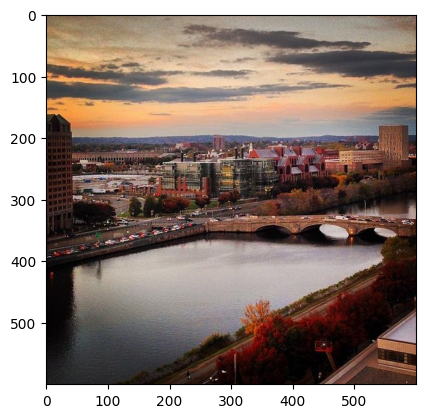

In [6]:
image = Image.open(img_path)
plt.imshow(image)

# Context Generation

In [7]:
inp = TEMPLATE['stage2'].format(sentence)
context = lvlm.generate(img_path,inp)
print(context)

The image shows a cityscape of Boston, Massachusetts, with a bridge over a river and a large building in the background. The city is known for its rich history, including the American Revolution and the founding of the United States. The bridge in the image is the Longfellow Bridge, which was completed in 1906 and named after the famous poet Henry Wadsworth Longfellow. The large building in the background is the Charles River Dam, which was completed in 1910 and played a significant role in flood control and hydroelectric power generation in the city. The image captures the essence of Boston's architectural and historical heritage.


# Contextual Fusion

- Original prediction

In [8]:
question = TEMPLATE['question'].format(sentence,aspect)
options = {"A). positive":"A). positive","B). neutral":"B). neutral","C). negative":"C). negative"}
prompt = {"question": question, "options": options}
dic_ori = msa.logit_generate(img_path,prompt)
print("Question: {}\n##################\nModel Response: {}\nProbability: {}".format(question,dic_ori['answer'],f"{{positive: {round(dic_ori['logit_score'][0],3)}, neutral: {round(dic_ori['logit_score'][1],3)}, negative: {round(dic_ori['logit_score'][2],3)}}}"))

Question: Sentence: "Good evening , Boston" Use the image as a visual aids to help you answer the question. What is the sentiment polarity of the aspect "Boston" in the sentence?
A). positive
B). neutral
C). negative
Answer with the option's letter from the given choices directly.
##################
Model Response: B). neutral
Probability: {positive: 0.3630000054836273, neutral: 0.5920000076293945, negative: 0.04500000178813934}


- Prediction with Context

In [9]:
question = TEMPLATE['question_context'].format(sentence,context,aspect)
prompt = {"question": question, "options": options}
dic_context = msa.logit_generate(img_path,prompt)
print("Question: {}\n##################\nModel Response: {}\nProbability: {}".format(question,dic_context['answer'],f"{{positive: {dic_context['logit_score'][0]}, neutral: {dic_context['logit_score'][1]}, negative: {dic_context['logit_score'][2]}}}"))

Question: Sentence: "Good evening , Boston". Context: "The image shows a cityscape of Boston, Massachusetts, with a bridge over a river and a large building in the background. The city is known for its rich history, including the American Revolution and the founding of the United States. The bridge in the image is the Longfellow Bridge, which was completed in 1906 and named after the famous poet Henry Wadsworth Longfellow. The large building in the background is the Charles River Dam, which was completed in 1910 and played a significant role in flood control and hydroelectric power generation in the city. The image captures the essence of Boston's architectural and historical heritage.". Use the image as a visual aids to help you answer the question. What is the sentiment polarity of the aspect "Boston" in the sentence?
A). positive
B). neutral
C). negative
Answer with the option's letter from the given choices directly.
##################
Model Response: A). positive
Probability: {pos

- Fusion

In [10]:
def contextual_fusion(prob_ori, prob_context, alpha, beta):
    """
    :param prob_ori: numpy 1d array-like, the probability of original
    :param prob_context: numpy 1d array-like, the probability of incorporating context
    :param alpha: float, the threshold of choosing hard sample
    :param beta: float, interpolation coefficient
    """
    delta = 2 * np.max(prob_ori) + np.min(prob_ori) - 1
    if delta > alpha:
        return prob_ori
    
    prob_fuse = prob_ori + beta * (prob_context - prob_ori)
    
    return prob_fuse

In [11]:
prob_final = contextual_fusion(dic_ori['logit_score'],dic_context['logit_score'],alpha=0.3,beta=0.4)
final_answer = ['A). positive','B). neutral','C). negative'][np.argmax(prob_final)]
print("Final Response: {}\nProbability: {}".format(final_answer,f"{{positive: {prob_final[0]}, neutral: {prob_final[1]}, negative: {prob_final[2]}}}"))

Final Response: A). positive
Probability: {positive: 0.5027803778648376, neutral: 0.4581635296344757, negative: 0.03905605524778366}
